In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import math
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

## Data Loading

In [7]:
def insertPic(folder, image_size=(150, 150), batch_size=100):
    all_images = []
    all_filenames = []
    all_labels = []

    label_dirs = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

    for label in label_dirs:
        label_path = os.path.join(folder, label)
        filenames = os.listdir(label_path)
        
        for i in range(0, len(filenames), batch_size):
            batch_filenames = filenames[i:i + batch_size]
            images = []
            labels = []
            for filename in batch_filenames:
                img_path = os.path.join(label_path, filename)
                img = cv.imread(img_path, cv.IMREAD_COLOR)
                
                if img is not None:
                    resized = cv.resize(img, image_size, interpolation=cv.INTER_AREA) 
                    images.append(resized)
                    labels.append(label)

            all_images.extend(images)
            all_filenames.extend(batch_filenames)
            all_labels.extend(labels)

    return all_images, all_filenames, all_labels

Jumlah total gambar: 0
Distribusi data per label:


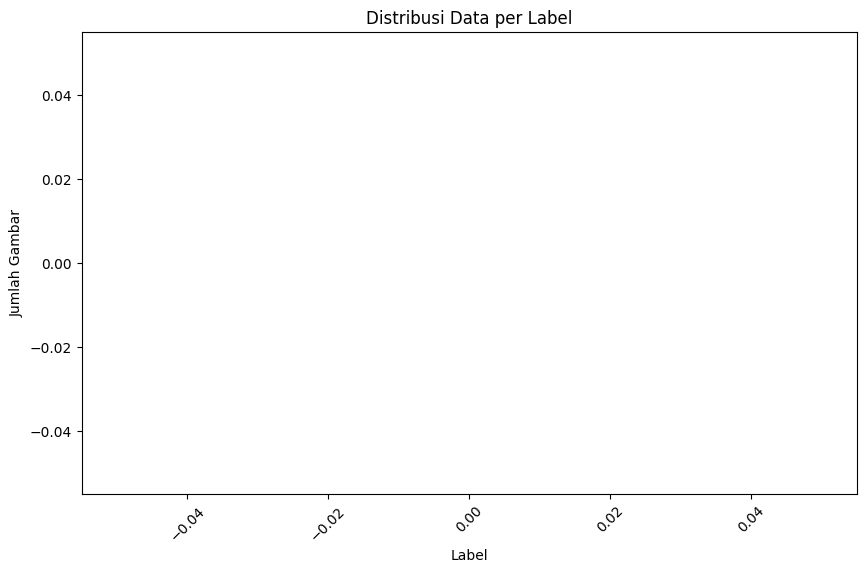

ValueError: 'a' cannot be empty unless no samples are taken

In [8]:
def eksploration(images, labels):
    print(f"Jumlah total gambar: {len(images)}")
    
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    print("Distribusi data per label:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Label')
    plt.ylabel('Jumlah Gambar')
    plt.title('Distribusi Data per Label')
    plt.xticks(rotation=45)
    plt.show()
    
    num_samples = 7
    sample_indices = np.random.choice(range(len(images)), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv.cvtColor(images[idx], cv.COLOR_BGR2RGB))
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()
    
images, filenames, labels = insertPic('FingerSimulDataset', image_size=(150, 150))
eksploration(images,labels)

## Data Preparation

### Data Augmentation

In [9]:
def rotation (image, derajat):
        rotated = image.copy()
        sudut= np.deg2rad(derajat)
        heighttengah = int((image.shape[1]-1)/2)
        widthtengah = int((image.shape[0]-1)/2)
        for i in range (rotated.shape[0]):
            for j in range (rotated.shape[1]):
                x=(i-heighttengah)*np.cos(sudut)+(j-widthtengah)*np.sin(sudut)
                y=-(i-heighttengah)*np.sin(sudut)+(j-widthtengah)*np.cos(sudut)
                x = int(x + heighttengah)
                y = int(y + widthtengah)
                if x>=0 and y>=0 and x<rotated.shape[0] and y<rotated.shape[1] :
                    rotated[i][j]= image[x][y]
        return rotated

In [10]:
def mirroring(image, axis):
        mirrored = image.copy()
        if axis == 0:
            for i in range (mirrored.shape[0]):
                for j in range (mirrored.shape[1]):
                    mirrored[i][j] = image[mirrored.shape[0]-1-i][j]
        elif axis == 1:
            for i in range (mirrored.shape[0]):
                for j in range (mirrored.shape[1]):
                    mirrored[i][j] = image[i][mirrored.shape[1]-1-j]
        return mirrored

In [11]:
def augmentasi(data, filenames, banyakData=4):
    augmented_data = []
    augmented_filenames = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_filenames.append(filenames[i])
        used_angles = set()
        for j in range(banyakData):
            image = data[i]
            possible_angles = [angle for angle in range(5, 360, 5) if angle not in used_angles]
            sudut = random.choice(possible_angles)
            while sudut in used_angles:
                sudut = random.randint(1, 360)
            used_angles.add(sudut)
            augment = random.randint(0, 1)
            if augment == 0:
                image = rotation(image, sudut)
                image = mirroring(image, 0)
            else:
                image = rotation(image, sudut)
                image = mirroring(image, 1)
            augmented_data.append(image)
            augmented_filenames.append(filenames[i])
    return augmented_data, augmented_filenames

In [12]:
augmentasiData, augmentasiFilenames = augmentasi(images, filenames)

0it [00:00, ?it/s]


In [13]:
def grayScaling(img):
    gaussKernel = np.ones((3,3))/9
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    filteredR = cv.filter2D(r,-1,gaussKernel)
    filteredG = cv.filter2D(g,-1,gaussKernel)
    filteredB = cv.filter2D(b,-1,gaussKernel)
    return np.round(filteredR/3 + filteredG/3 + filteredB/3).astype(np.uint8)

In [14]:
def grayScalingData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayScaling(data[i]))
    return gray_data

In [15]:
grayAugmentedData = grayScalingData(augmentasiData)

0it [00:00, ?it/s]


In [16]:
def findPixel(img,skala=256):
    pixel = np.zeros(skala)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel[int(img[i,j])] =  pixel[int(img[i,j])] + 1
    return pixel

def findProbability(img, pixel,skala=256):
    for i in range(skala):
        pixel[i] = pixel [i] / (img.shape[0] * img.shape[1])
    return pixel

def findCumulative(arr,skala=256):
    for i in range(skala):
        if i != 0:
            arr[i] = arr[i] + arr[i-1]
    return arr

def equalization(img):
    pixel = findPixel(img)
    pixel = findProbability(img,pixel)
    pixel = findCumulative(pixel)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j] = pixel[int(img[i,j])] * 255
    return img

def equalizationData(data):
    equalized_data = []
    for i in tqdm(range(len(data))):
        equalized_data.append(equalization(data[i]))
    return equalized_data

In [17]:
equalData = equalizationData(grayAugmentedData)

0it [00:00, ?it/s]


### Preprocessing

#### Preprocessing 1

In [18]:
def addPadd(image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2
    left = i
    right = (kernel.shape[1]-1)-i
    top = j
    bottom = (kernel.shape[0]-1)-j
    results = np.pad(image, ((top, bottom),(left, right)), mode='edge')
    return results

def sortArray(filter):
    for i in range(len(filter)-1):
        for j in range(i+1,len(filter)):
            if filter[i] > filter[j]:
                temp = filter[i]
                filter[i] = filter[j]
                filter[j] = temp
    return filter

def findMedian(filter):
    sorted_array = sortArray(filter)
    length = len(filter)
    if length % 2 == 0:
        x1 = (length // 2) - 1
        x2 = x1 + 1
        value = (sorted_array[x1] + sorted_array[x2]) // 2
        return int(value)
    else:
        value = (length // 2)
        return int(sorted_array[value])

def medianFiltering(image, kernel):
    result = np.zeros([image.shape[0], image.shape[1]], dtype=np.uint8)
    paddingImage = addPadd(image, kernel)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            temp = []
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp.append(paddingImage[i+k, j+l])
            value = findMedian(temp)
            result[i][j] = value
    return result

def medianFilteringData(data):
    kernel = np.ones((3,3))
    median_filtered_data = []
    for i in tqdm(range(len(data))):
        median_filtered_data.append(medianFiltering(data[i], kernel))
    return median_filtered_data

In [ ]:
medianEqualData = medianFilteringData(equalData)

In [ ]:
def normalisasi (image):
    min_val = np.min(image)
    max_val = np.max(image)
    
    normalisasi_img = (image-min_val)/(max_val-min_val)
    uint8_img = (normalisasi_img * 255).astype(np.uint8)
    
    return uint8_img

def normalisasiData(data):
    normalized_data = []
    for i in tqdm(range(len(data))):
        normalized_data.append(normalisasi(data[i]))
    return normalized_data

In [ ]:
normalData = normalisasiData(medianEqualData)

#### Preprocessing n

### Feature Extraction

In [ ]:
def calculate_glcm(image, distances=[1], angles=[0, 45, 90, 135], levels=256):
    glcm_matrices = []
    max_val = np.max(image)
    min_val = np.min(image)
    image_normalized = ((image - min_val) / (max_val - min_val) * (levels - 1)).astype(np.uint8)
    
    for angle in angles:
        glcm_matrix = np.zeros((levels, levels))
        for distance in distances:
            offset_x = int(round(distance * np.cos(np.radians(angle))))
            offset_y = int(round(distance * np.sin(np.radians(angle))))
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if 0 <= i + offset_y < image.shape[0] and 0 <= j + offset_x < image.shape[1]:
                        pixel_value = image_normalized[i, j]
                        neighbor_value = image_normalized[i + offset_y, j + offset_x]
                        glcm_matrix[pixel_value, neighbor_value] += 1
        glcm_matrices.append(glcm_matrix)
    return glcm_matrices

def calculate_glcm_features(glcm_matrices):
    features = []
    for glcm_matrix in glcm_matrices:
        glcm_matrix /= np.sum(glcm_matrix)
        
        contrast = np.sum(glcm_matrix * np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        dissimilarity = np.sum(glcm_matrix * np.abs(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))

        homogeneity = np.sum(glcm_matrix / (1 + np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1]))))
        energy = np.sum(np.square(glcm_matrix))
        correlation = np.sum((np.arange(glcm_matrix.shape[0]) - np.mean(glcm_matrix)) * 
                             (np.arange(glcm_matrix.shape[1]) - np.mean(glcm_matrix)) * glcm_matrix / 
                             (np.std(glcm_matrix) ** 2))
        entropy = -np.sum(glcm_matrix * np.log(glcm_matrix + 1e-10))
        asm = np.sum(np.square(glcm_matrix))
        
        features.append({
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'entropy': entropy,
            'ASM': asm
        })
    return features


edge_images_prewitt_rotated = [
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(calculate_glcm(edge_image))

glcm_features = calculate_glcm_features(glcm_matrices)

data = []
columns = ['Image', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'ASM']
for angle in [0, 45, 90, 135]:
    columns.extend([f'contrast_{angle}', f'dissimilarity_{angle}', f'homogeneity_{angle}', 
                    f'energy_{angle}', f'correlation_{angle}', f'asm_{angle}', f'entropy_{angle}'])

for i, features in enumerate(glcm_features):
    row = [i + 1, features['contrast'], features['dissimilarity'], features['homogeneity'], 
           features['energy'], features['correlation'], features['entropy'], features['ASM']]
    for angle in [0, 45, 90, 135]:
        row.extend([features['contrast'], features['dissimilarity'], features['homogeneity'], 
                    features['energy'], features['correlation'], features['entropy'], features['ASM']])
    data.append(row)

df = pd.DataFrame(data, columns=columns)

print(df)
df.head()

### Features Selection

In [ ]:
def feature_selection_correlation(results):
    data = []
    columns = ['Filename', 'Label', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM', 'Entropy']
    for fname, label, features in results:
        row = [fname, label]
        row.extend(features.values())
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    
    df['Label'] = df['Label'].astype('category').cat.codes
    
    numeric_df = df.drop(columns=['Filename'])
    
    corr = numeric_df.corr()
    
    plt.figure(figsize=(10, 8))
    plt.title("Matriks Korelasi Fitur")
    plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.index)), corr.index)
    for i in range(len(corr.columns)):
        for j in range(len(corr.index)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    plt.show()
    
    selected_features = corr['Label'][(corr['Label'] > 0.99) | (corr['Label'] < -0.99)].index.tolist()
    selected_features.remove('Label')
    
    print("Selected Features:", selected_features)
    
    return df, selected_features

edge_images_prewitt_rotated = [
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(calculate_glcm(edge_image))

glcm_features = calculate_glcm_features(glcm_matrices)

results = []
for i, features in enumerate(glcm_features):
    results.append((f'Filename_{i}', f'Label_{i}', features))

df_selected, selected_features = feature_selection_correlation(results)
print("Selected Features:", selected_features)
print(df_selected.head())

### Splitting Data

In [ ]:
X = df_selected.drop(columns=['Label'])
y = df_selected['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

### Normalization

In [ ]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

def min_max_normalization(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

X_train_normalized = X_train_numeric.apply(min_max_normalization, axis=0)

X_test_normalized = X_test_numeric.apply(min_max_normalization, axis=0)

print("Normalized Training data shape :", X_train_normalized.shape)
print("Normalized Testing data shape:", X_test_normalized.shape)


## Modeling

In [ ]:
X_train_numeric = X_train.drop(columns=['Filename'])
X_test_numeric = X_test.drop(columns=['Filename'])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

## Evaluation

In [ ]:
X_train_numeric = X_train.drop(columns=['Filename'])
X_test_numeric = X_test.drop(columns=['Filename'])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train, average='macro', zero_division='warn')
precision_test = precision_score(y_test, y_pred_test, average='macro', zero_division='warn')

recall_train = recall_score(y_train, y_pred_train, average='macro', zero_division='warn')
recall_test = recall_score(y_test, y_pred_test, average='macro', zero_division='warn')

f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division='warn')
f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division='warn')

print("Evaluation Metrics:")
print("-----------------------------------------------------")
print("| Metric      |   Training Set   |   Testing Set    |")
print("-----------------------------------------------------")
print("| Accuracy    |    {:.4f}        |    {:.4f}        |".format(accuracy_train, accuracy_test))
print("| Precision   |    {:.4f}        |    {:.4f}        |".format(precision_train, precision_test))
print("| Recall      |    {:.4f}        |    {:.4f}        |".format(recall_train, recall_test))
print("| F1-score    |    {:.4f}        |    {:.4f}        |".format(f1_train, f1_test))
print("-----------------------------------------------------")

print("Confusion Matrix:")
print("Training Set")
print(conf_matrix_train)
print("\nTesting Set")
print(conf_matrix_test)